# Unicycle Path Tracking via Feedback Linearization & LQR

## 1. Look-Ahead Point Transformation
The unicycle center $\mathbf{x} = [x_1, x_2, x_3]^T$ is non-holonomic. We define a holonomic point $\mathbf{y}$ at distance $L$ in front of the center:
$$ \mathbf{y}(t) = \begin{bmatrix} y_1 \\ y_2 \end{bmatrix} = \begin{bmatrix} x_1 + L \cos(x_3) \\ x_2 + L \sin(x_3) \end{bmatrix} $$

## 2. Linearized Dynamics
The evolution of point $\mathbf{y}$ is governed by the virtual velocity $\mathbf{v}(t)$:
$$ \mathbf{y}(t+1) = \mathbf{y}(t) + \tau \mathbf{v}(t) + \tau \mathbf{\tilde{w}}(t) $$
Where $\mathbf{v}(t)$ is the output of our LQR controller. To achieve this $\mathbf{v}$, the actual robot commands $\mathbf{u} = [u_1, u_2]^T$ (linear and angular velocity) must be:
$$ \mathbf{u}(t) = \mathbf{M}(x_3)^{-1} \mathbf{v}(t) $$
Where $\mathbf{M}(x_3)$ is the decoupling matrix:
$$ \mathbf{M}(x_3) = \begin{bmatrix} \cos(x_3) & -L\sin(x_3) \\ \sin(x_3) & L\cos(x_3) \end{bmatrix} \implies \mathbf{M}^{-1} = \begin{bmatrix} \cos(x_3) & \sin(x_3) \\ -\frac{1}{L}\sin(x_3) & \frac{1}{L}\cos(x_3) \end{bmatrix} $$

## 3. Optimal Control (LQR)
Since the point $\mathbf{y}$ behaves like a **Single Integrator**, we use the same LQR cost function:
$$ J = \sum_{t=0}^{\infty} (\mathbf{e}_y^T \mathbf{Q} \mathbf{e}_y + \mathbf{v}_{fb}^T \mathbf{R} \mathbf{v}_{fb}) $$
The total virtual velocity is:
$$ \mathbf{v}(t) = \underbrace{\frac{1}{\tau} \Delta \mathbf{y}_{ref}(t)}_{\text{Feedforward}} - \underbrace{\mathbf{K} \mathbf{e}_y(t)}_{\text{LQR Feedback}} $$


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.linalg import solve_discrete_are


In [79]:
# Simulation Parameters
tau = 0.1
L = 0.3            # Look-ahead distance (crucial for unicycle)
u1_lim = [0.25, 1] # Linear velocity constraints [min, max]
u2_lim = [-1, 1]   # Angular velocity constraints
w_bound = 0.05     # Noise bound from slide

# 1. Define Virtual Linear System (for point y)
A = np.eye(2)
B = tau * np.eye(2)

# 2. LQR Weights
Q = np.diag([15.0, 15.0]) # Penalty for tracking error
R = np.diag([1.0, 1.0])   # Penalty for virtual control effort

# 3. Solve for K
P = solve_discrete_are(A, B, Q, R)
K = np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)

print(f"Optimal LQR Gain K:\n{K}")


Optimal LQR Gain K:
[[3.19493346 0.        ]
 [0.         3.19493346]]


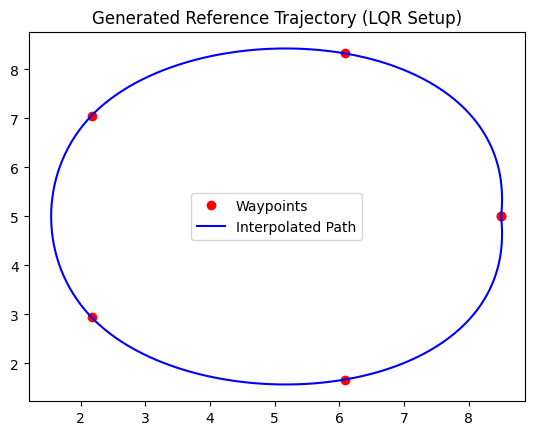

In [ ]:
# Create waypoints within the [0, 10] workspace
waypoints = np.array([
    [1, 1],
    [3, 8],
    [7, 7],
    [9, 2]
])

# # Circle
# radius = 3.5
# center = [5.0, 5.0]
# angles = np.linspace(0, 2 * np.pi, 6)
# waypoints = np.array([
#     [center[0] + radius * np.cos(a), center[1] + radius * np.sin(a)] 
#     for a in angles
# ])

steps = 500
s = np.linspace(0, 1, len(waypoints))
s_fine = np.linspace(0, 1, steps)
cs = CubicSpline(s, waypoints)
path = cs(s_fine) # This is y_ref

plt.plot(waypoints[:,0], waypoints[:,1], 'ro', label='Waypoints')
plt.plot(path[:,0], path[:,1], 'b-', label='Interpolated Path')
plt.title("Generated Reference Trajectory (LQR Setup)")
plt.legend()
plt.show()


In [84]:
# Initial State: [x1, x2, x3] 
# Start at waypoint 0, facing toward waypoint 1
curr_x = np.array([4.0, 3.0, np.pi/4]) 
history_center = []
history_y = []

for t in range(steps - 1):
    # 1. Map current state to look-ahead point y
    theta = curr_x[2]
    curr_y = np.array([
        curr_x[0] + L * np.cos(theta),
        curr_x[1] + L * np.sin(theta)
    ])
    history_center.append(curr_x.copy())
    history_y.append(curr_y.copy())
    
    # 2. Calculate Error for point y
    error_y = curr_y - path[t]
    
    # 3. Calculate Virtual Velocity (Feedforward + LQR Feedback)
    v_ff = (path[t+1] - path[t]) / tau
    v_fb = -K @ error_y
    v = v_ff + v_fb
    
    # 4. Transform Virtual v to Real Unicycle u (u1, u2)
    # Inverse of M matrix
    inv_M = np.array([
        [np.cos(theta),           np.sin(theta)],
        [-np.sin(theta)/L,        np.cos(theta)/L]
    ])
    u = inv_M @ v
    
    # 5. Apply Constraints (Specific to your slide)
    u[0] = np.clip(u[0], u1_lim[0], u1_lim[1]) # Linear Velocity
    u[1] = np.clip(u[1], u2_lim[0], u2_lim[1]) # Angular Velocity
    
    # 6. Physics Update with original Unicycle Dynamics + Noise
    w = np.random.uniform(-w_bound, w_bound, size=3)
    
    new_x1 = curr_x[0] + tau * (u[0] * np.cos(theta) + w[0])
    new_x2 = curr_x[1] + tau * (u[0] * np.sin(theta) + w[1])
    new_x3 = curr_x[2] + tau * (u[1] + w[2])
    
    curr_x = np.array([new_x1, new_x2, new_x3])

history_center = np.array(history_center)
print("Unicycle Simulation Complete.")


Unicycle Simulation Complete.


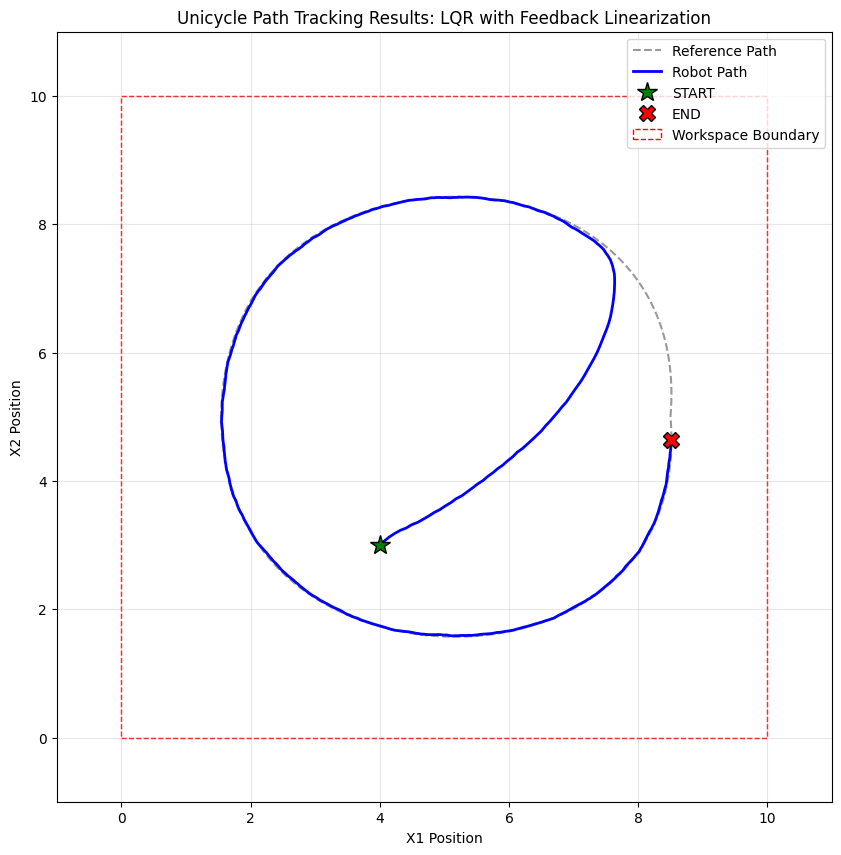

In [85]:
plt.figure(figsize=(10, 10))

# Plot Reference Path (The target trajectory for the look-ahead point y)
plt.plot(path[:, 0], path[:, 1], 'k--', alpha=0.4, label='Reference Path')

# Plot Robot Trajectory (The actual center of the unicycle)
plt.plot(history_center[:, 0], history_center[:, 1], 'b-', linewidth=2, label='Robot Path')

# Markers for Start and End positions
plt.plot(history_center[0, 0], history_center[0, 1], 'g*', markersize=15, label='START', markeredgecolor='k')
plt.plot(history_center[-1, 0], history_center[-1, 1], 'rX', markersize=12, label='END', markeredgecolor='k')

# Workspace Constraints (Set to [0, 10] x [0, 10] as per the Unicycle model slide)
plt.gca().add_patch(plt.Rectangle((0, 0), 10, 10, fill=False, color='red', linestyle='--', label='Workspace Boundary'))

# Plot Formatting
plt.xlim(-1, 11)
plt.ylim(-1, 11)
plt.xlabel("X1 Position")
plt.ylabel("X2 Position")
plt.title("Unicycle Path Tracking Results: LQR with Feedback Linearization")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()


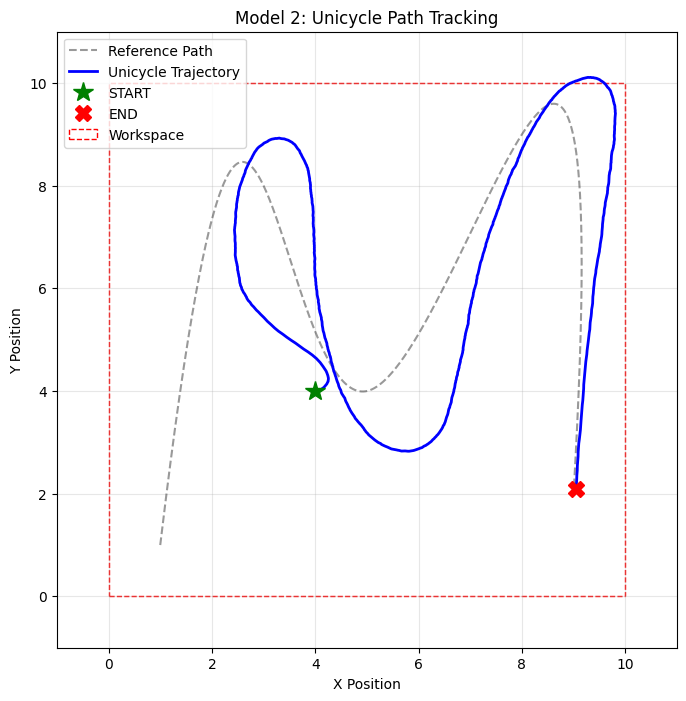

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Simulation Parameters
tau = 0.1          # Sampling time (s)
v_min, v_max = 0.25, 1.0  # Linear velocity constraints
w_max = 1.0               # Angular velocity constraint
noise_bound = 0.05        # Noise bound for x, y, theta

# Gains (Tuned for stability)
Kx = 2.0
Ky = 2.0
Ktheta = 5.0
K = np.diag([Kx, Ky, Ktheta])

# 1. Define Waypoints (Shifted to [0, 10] range as per Model 2)
waypoints = np.array([
    [1, 1],
    [3, 8],
    [5, 4],
    [8, 9],
    [9, 2]
])

# 2. Create Smooth Trajectory
steps = 1000
s = np.linspace(0, 1, len(waypoints))
s_fine = np.linspace(0, 1, steps)
cs = CubicSpline(s, waypoints)
path_xy = cs(s_fine)

# 3. Derive Reference Heading (theta_ref) and Reference Velocity (v_ref)
# We need these for the feedforward part of the Unicycle
path_diff = np.diff(path_xy, axis=0)
theta_ref = np.arctan2(path_diff[:, 1], path_diff[:, 0])
theta_ref = np.append(theta_ref, theta_ref[-1]) # Match length

v_ref = np.sqrt(np.sum(path_diff**2, axis=1)) / tau
v_ref = np.append(v_ref, v_ref[-1])
v_ref = np.clip(v_ref, v_min, v_max) # Ensure path is feasible for the robot

# --- Starting Point [x, y, theta] ---
curr_x = np.array([4, 4, 0.0]) 
# ------------------------------------

history = []

for t in range(steps - 1):
    history.append(curr_x.copy())
    
    # 1. Calculate Error e(t)
    # Important: Normalize theta error to [-pi, pi]
    err = curr_x - np.array([path_xy[t,0], path_xy[t,1], theta_ref[t]])
    err[2] = np.arctan2(np.sin(err[2]), np.cos(err[2]))
    
    # 2. Linearized Jacobians (Lyapunov Indirect Method)
    # A is not strictly needed for this specific law, but B defines how inputs map to states
    cos_th = np.cos(curr_x[2])
    sin_th = np.sin(curr_x[2])
    
    # 3. Control Law (Feedforward + Linearized Feedback)
    # We map Cartesian errors to the Unicycle inputs (v, omega)
    # u1 (v) corrects longitudinal error, u2 (omega) corrects orientation/lateral error
    u_ff = np.array([v_ref[t], (theta_ref[t+1] - theta_ref[t])/tau])
    
    # Feedback: Project Cartesian error into robot frame
    ex_robot = err[0] * cos_th + err[1] * sin_th
    ey_robot = -err[0] * sin_th + err[1] * cos_th
    
    v_cmd = v_ref[t] - Kx * ex_robot
    w_cmd = u_ff[1] - Ky * ey_robot - Ktheta * err[2]
    
    u = np.array([v_cmd, w_cmd])
    
    # 4. Apply Saturation (Constraint U)
    u[0] = np.clip(u[0], v_min, v_max) # Note the 0.25 minimum!
    u[1] = np.clip(u[1], -w_max, w_max)
    
    # 5. Physics Update (Unicycle Equations) with Noise
    w = np.random.uniform(-noise_bound, noise_bound, size=3)
    
    curr_x[0] += tau * (u[0] * np.cos(curr_x[2]) + w[0])
    curr_x[1] += tau * (u[0] * np.sin(curr_x[2]) + w[1])
    curr_x[2] += tau * (u[1] + w[2])
    curr_x[2] = np.arctan2(np.sin(curr_x[2]), np.cos(curr_x[2])) # Keep theta normalized

history = np.array(history)

# --- Visualization ---
plt.figure(figsize=(8, 8))
plt.plot(path_xy[:, 0], path_xy[:, 1], 'k--', alpha=0.4, label='Reference Path')
plt.plot(history[:, 0], history[:, 1], 'b-', linewidth=2, label='Unicycle Trajectory')
plt.plot(history[0, 0], history[0, 1], 'g*', markersize=15, label='START')
plt.plot(history[-1, 0], history[-1, 1], 'rX', markersize=12, label='END')

# Workspace Boundary [0, 10]
plt.gca().add_patch(plt.Rectangle((0, 0), 10, 10, fill=False, color='red', linestyle='--', label='Workspace'))

plt.xlim(-1, 11); plt.ylim(-1, 11)
plt.xlabel("X Position"); plt.ylabel("Y Position")
plt.title("Model 2: Unicycle Path Tracking")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
